<a href="https://colab.research.google.com/github/vigouredelaruse/python-notebooks/blob/master/UDE_problem_spring_mass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Damped Spring–Mass System with a Universal Differential Equation (UDE)

This notebook demonstrates how to:

1. **Generate synthetic data** from a known damped spring–mass system.
2. **Construct a universal differential equation (UDE)** that blends known physics with a neural network.
3. **Train the neural network** parameters to match noisy data.
4. **Visualize** the trained model's performance.

We'll use:
- **NumPy** and **Matplotlib** for data manipulation and plotting.
- **`scipy.integrate.solve_ivp`** to generate synthetic data.
- **PyTorch** for neural network training.
- **`torchdiffeq`** for differentiable ODE solvers in PyTorch (we'll use a Runge-Kutta method, `rk4`).


## 1. Install/Import Necessary Packages
If you're running this locally or in a new environment, you may need to install `torch` and `torchdiffeq`. Run the following lines in a code cell or in your terminal if needed:
```
!pip install torch torchdiffeq
```
Then import everything we need:


In [ ]:
!pip install torch torchdiffeq

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint

# For inline plotting in many notebook environments
%matplotlib inline

## 2. Generate Synthetic "True" Data
We'll simulate the classical damped spring–mass system with the ODE:
\begin{align*}
m \frac{d^2 x}{dt^2} + c\frac{dx}{dt} + kx = 0,
\end{align*}
where \(c\_\text{true}\) is the *actual* damping (unknown in the real scenario, but here we do know it to generate data). We use `scipy.integrate.solve_ivp` to generate the solution, then add noise.

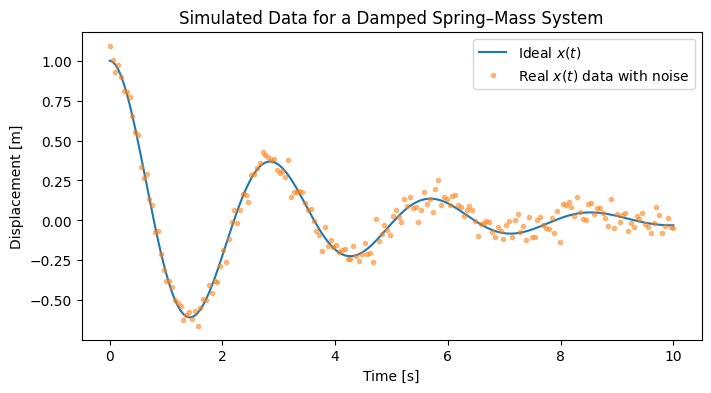

In [ ]:
# Physical parameters (assumed known in the real problem)
m = 1.0     # mass
k = 5.0     # spring constant

# "True" damping coefficient (unknown in practice)
c_true = 0.7

def damped_spring_mass(t, y):
    """
    Classical ODE for a damped spring–mass:
        y = [x, x_dot]
        dy/dt = [x_dot, x_ddot]
        where x_ddot = -(c_true/m)*x_dot - (k/m)*x
    """
    x, x_dot = y
    x_ddot = -(c_true/m)*x_dot - (k/m)*x
    return [x_dot, x_ddot]

# Initial conditions
x0 = 1.0  # initial displacement
v0 = 0.0  # initial velocity
y0 = [x0, v0]

# Time span for simulation
t_start, t_end = 0.0, 10.0
t_eval = np.linspace(t_start, t_end, 200)  # 200 time points

# Solve the classical ODE
sol = solve_ivp(damped_spring_mass, [t_start, t_end], y0, t_eval=t_eval)
x_true = sol.y[0, :]  # x(t)
v_true = sol.y[1, :]  # x_dot(t)

# Add noise to simulate experimental data
noise_level = 0.05
x_noisy = x_true + noise_level * np.random.randn(len(x_true))
v_noisy = v_true + noise_level * np.random.randn(len(v_true))

# Plot the noisy data vs. true solution
plt.figure(figsize=(8,4))
plt.plot(t_eval, x_true, label='Ideal $x(t)$')
plt.plot(t_eval, x_noisy, 'o', label='Real $x(t)$ data with noise', alpha=0.5, markersize=3)
plt.title("Simulated Data for a Damped Spring–Mass System")
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")
plt.legend()
plt.show()


## 3. Defining the Neural Network

We'll create a simple feed-forward neural network, `DampeningNN`, that takes the current state \((x, \dot{x})\) (and optionally time) and outputs a scalar.

This scalar is interpreted as an unknown part of the dynamics—for example, the damping force.

In [ ]:
class DampeningNN(nn.Module):
    """
    A simple feed-forward neural network that takes:
      - current displacement u1,
      - current velocity u2,
      - optionally time t,
    and outputs an estimate of the 'damping force' (or part of it).
    """
    def __init__(self, input_dim=2, hidden_dim=16):
        super(DampeningNN, self).__init__()

        # You can include time as input (then input_dim=3)
        # For simplicity, we only use (u1, u2) => input_dim=2
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)  # output is a single value for damping
        )

    def forward(self, t, u):
        # u is (batch_size, 2) -> [x, x_dot]
        # t is a scalar or shape (batch_size, )
        # We'll just ignore t for now, or we could incorporate it
        return self.net(u)


## 4. Defining the UDE ODE Class

We know part of the physics: \(- \frac{k}{m} x\). We let the neural network learn the damping part \(-\frac{1}{m}\cdot(\text{NN}(x,\dot{x}))\).

Hence, the overall ODE is:
\begin{align*}
u_1' &= u_2,\\
u_2' &= - \frac{k}{m} u_1 \; - \frac{1}{m}\,\underbrace{\mathrm{NN}(u_1, u_2)}_{\text{unknown damping}}.
\end{align*}

In [ ]:
class SpringMassUDE(nn.Module):
    """
    This class wraps the ODE:
        du1/dt = u2
        du2/dt = -(k/m)*u1 - (1/m)*NN(u1, u2)
    """
    def __init__(self, m, k, nn_model):
        super(SpringMassUDE, self).__init__()
        self.m = m
        self.k = k
        self.nn_model = nn_model  # the neural network for damping

    def forward(self, t, y):
        """
        y: [u1, u2]
        returns dy/dt
        """
        # For batch ODE solving, y might have shape (batch_size, 2).
        # Usually for a single trajectory, batch_size=1.
        u1, u2 = y[..., 0], y[..., 1]

        # Reshape or combine for feeding the NN
        u_cat = torch.stack([u1, u2], dim=-1)

        # Damping force from NN
        damp_force = self.nn_model(t, u_cat)
        damp_force = damp_force.squeeze(dim=-1)  # shape (batch_size,)

        # The ODE:
        du1dt = u2
        du2dt = - (self.k / self.m) * u1 - (1.0 / self.m) * damp_force

        return torch.stack([du1dt, du2dt], dim=-1)


### Convert NumPy data to PyTorch Tensors
We need our time and data in tensor form to be used in a training loop.

In [ ]:
t_train_torch = torch.tensor(t_eval, dtype=torch.float32)  # shape (N,)
x_train_torch = torch.tensor(x_noisy, dtype=torch.float32) # shape (N,)
v_train_torch = torch.tensor(v_noisy, dtype=torch.float32) # shape (N,)

print("Time tensor shape:", t_train_torch.shape)
print("Displacement tensor shape:", x_train_torch.shape)
print("Velocity tensor shape:", v_train_torch.shape)


Time tensor shape: torch.Size([200])
Displacement tensor shape: torch.Size([200])
Velocity tensor shape: torch.Size([200])


## 5. Function for Forward Simulation with `torchdiffeq`

We'll define a helper function `forward_sim` that:
1. Takes an ODE model (`net_ode`) such as our UDE.
2. An initial condition `y0`.
3. A set of time points `t_points`.
4. Returns the solution over those time points using `odeint`.

We'll specify the method as `rk4` (4th-order Runge–Kutta).

In [ ]:
def forward_sim(net_ode, y0, t_points):
    """
    net_ode: an instance of SpringMassUDE
    y0: initial condition, shape (2,)
    t_points: 1D tensor of time points at which we want the solution
    returns: solution at those time points, shape (len(t_points), 2)
    """
    y0_torch = y0.unsqueeze(0)  # shape (1, 2) for batch dimension
    sol = odeint(net_ode, y0_torch, t_points, method='rk4')
    # sol shape is (len(t_points), batch_size=1, 2)
    return sol[:, 0, :]  # remove batch dim -> shape (len(t_points), 2)

## 6. Instantiate the NN & UDE, and Prepare for Training


In [ ]:
# Choose dimensions
hidden_dim = 16
damping_nn = DampeningNN(input_dim=2, hidden_dim=hidden_dim)
ude = SpringMassUDE(m=m, k=k, nn_model=damping_nn)

# Initial condition for training (use the noisy data's first point)
y0_torch = torch.tensor([x_noisy[0], v_noisy[0]], dtype=torch.float32)

# Optimizer
optimizer = optim.Adam(ude.parameters(), lr=1e-2)

print("Neural Network model:")
print(damping_nn)

print("\nUDE parameters:")
for name, param in ude.named_parameters():
    print(name, param.shape)

Neural Network model:
DampeningNN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

UDE parameters:
nn_model.net.0.weight torch.Size([16, 2])
nn_model.net.0.bias torch.Size([16])
nn_model.net.2.weight torch.Size([16, 16])
nn_model.net.2.bias torch.Size([16])
nn_model.net.4.weight torch.Size([1, 16])
nn_model.net.4.bias torch.Size([1])


## 7. Training Loop
We'll:
1. Solve the ODE forward in time using the current NN.
2. Compare the predictions \(x(t)\) and \(\dot{x}(t)\) to the noisy data.
3. Compute a mean-squared error (MSE) loss.
4. Backpropagate and update NN weights.
5. Repeat for multiple epochs.


In [ ]:
num_epochs = 100
loss_history = []
print_interval = 1

for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Forward simulation from t_start to t_end
    sol_pred = forward_sim(ude, y0_torch, t_train_torch)
    # sol_pred shape = (N, 2), where N = len(t_eval)
    x_pred = sol_pred[:, 0]
    v_pred = sol_pred[:, 1]

    # Define a loss: MSE on displacement (and optionally velocity)
    loss_x = torch.mean((x_pred - x_train_torch)**2)
    loss_v = torch.mean((v_pred - v_train_torch)**2)
    # Weighted sum or just x
    loss = 0.5*loss_x + 0.5*loss_v

    # Backprop
    loss.backward()
    optimizer.step()

    # Store the loss for plotting
    loss_history.append(loss.item())

    if (epoch+1) % print_interval == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss = {loss.item():.6f}")


Epoch 1/100, Loss = 0.021688
Epoch 2/100, Loss = 0.021212
Epoch 3/100, Loss = 0.020522
Epoch 4/100, Loss = 0.019656
Epoch 5/100, Loss = 0.018651
Epoch 6/100, Loss = 0.017543
Epoch 7/100, Loss = 0.016365
Epoch 8/100, Loss = 0.015151
Epoch 9/100, Loss = 0.013930
Epoch 10/100, Loss = 0.012731
Epoch 11/100, Loss = 0.011580
Epoch 12/100, Loss = 0.010502
Epoch 13/100, Loss = 0.009516
Epoch 14/100, Loss = 0.008641
Epoch 15/100, Loss = 0.007889
Epoch 16/100, Loss = 0.007269
Epoch 17/100, Loss = 0.006786
Epoch 18/100, Loss = 0.006435
Epoch 19/100, Loss = 0.006210
Epoch 20/100, Loss = 0.006098
Epoch 21/100, Loss = 0.006079
Epoch 22/100, Loss = 0.006132
Epoch 23/100, Loss = 0.006230
Epoch 24/100, Loss = 0.006350
Epoch 25/100, Loss = 0.006467
Epoch 26/100, Loss = 0.006560
Epoch 27/100, Loss = 0.006613
Epoch 28/100, Loss = 0.006617
Epoch 29/100, Loss = 0.006571
Epoch 30/100, Loss = 0.006476
Epoch 31/100, Loss = 0.006342
Epoch 32/100, Loss = 0.006180
Epoch 33/100, Loss = 0.006004
Epoch 34/100, Loss 

### 7.1 Plot the Training Loss


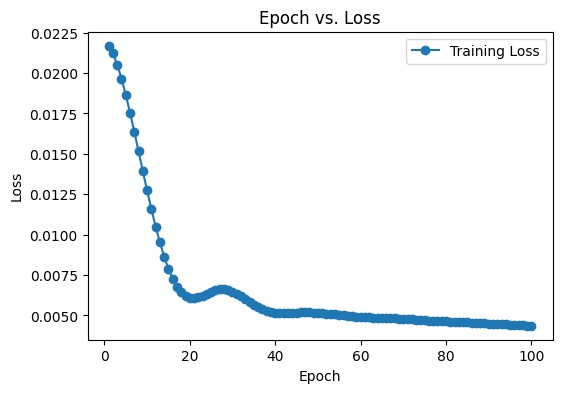

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(range(1, num_epochs+1), loss_history, marker='o', label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs. Loss")
plt.legend()
plt.show()


## 8. Evaluate the Final Learned Model
After training, we solve the ODE again with the learned neural network and compare to the true data (and the noisy data).

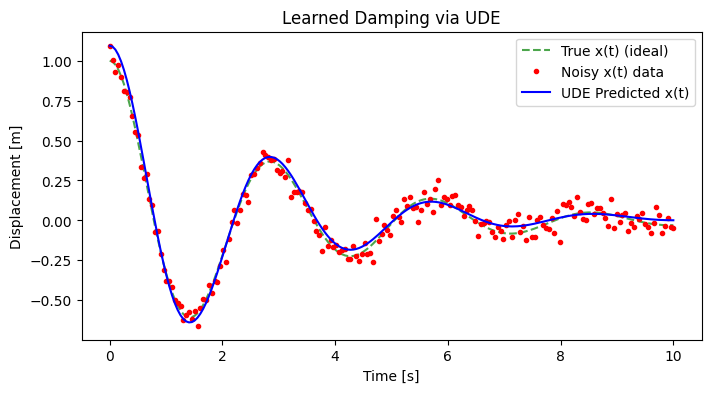

In [ ]:
sol_final = forward_sim(ude, y0_torch, t_train_torch).detach().numpy()
x_final = sol_final[:, 0]
v_final = sol_final[:, 1]

# Plot the final results
plt.figure(figsize=(8,4))
plt.plot(t_eval, x_true, 'g--', label='True x(t) (ideal)', alpha=0.7)
plt.plot(t_eval, x_noisy, 'ro', label='Noisy x(t) data', markersize=3)
plt.plot(t_eval, x_final, 'b-', label='UDE Predicted x(t)')
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")
plt.legend()
plt.title("Learned Damping via UDE")
plt.show()


## 9. Summary
- We generated synthetic data for a damped spring–mass system.
- We built a Universal Differential Equation (UDE) that combines known physics (spring term) with a neural network (learned damping).
- Using `torchdiffeq` to integrate the ODE and PyTorch to optimize the NN, we matched noisy training data.

This approach demonstrates how you can incorporate partial physical knowledge and let a neural network learn the unknown parts of the system.